In [1]:
!pip install git+https://github.com/aleju/imgaug


  Cloning https://github.com/aleju/imgaug to /tmp/pip-req-build-mrbba2f1
  Running command git clone -q https://github.com/aleju/imgaug /tmp/pip-req-build-mrbba2f1
  Created wheel for imgaug: filename=imgaug-0.2.9-cp36-none-any.whl size=792284 sha256=d702c1ce1ca0b3d034ea620ca199e95b25c6379619f129f49ea6d3278fcbc437
  Stored in directory: /tmp/pip-ephem-wheel-cache-98ihzang/wheels/9c/f6/aa/41dcf2f29cc1de1da4ad840ef5393514bead64ac9e644260ff
Successfully built imgaug
ERROR: albumentations 0.3.0 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: imgaug 0.2.6
    Uninstalling imgaug-0.2.6:
      Successfully uninstalled imgaug-0.2.6


In [2]:
import torch
import random
import numpy as np # linear algebra
random.seed(1)
np.random.seed(1)
torch.manual_seed(1)
torch.cuda.manual_seed(1)
torch.backends.cudnn.deterministic = True


import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['sample_submission.csv', 'plates']


In [3]:
data_root = '../input/plates/plates/'
print(os.listdir(data_root))

['train', 'test']


In [4]:
import shutil 
from tqdm import tqdm

train_dir = 'train'
val_dir = 'val'

class_names = ['cleaned', 'dirty']

for dir_name in [train_dir, val_dir]:
    for class_name in class_names:
        os.makedirs(os.path.join(dir_name, class_name), exist_ok=True)

for class_name in class_names:
    source_dir = os.path.join(data_root, 'train', class_name)
    for i, file_name in enumerate(tqdm(os.listdir(source_dir))):
        if i % 6 != 0:
            dest_dir = os.path.join(train_dir, class_name) 
        else:
            dest_dir = os.path.join(val_dir, class_name)
        shutil.copy(os.path.join(source_dir, file_name), os.path.join(dest_dir, file_name))

100%|██████████| 20/20 [00:00<00:00, 611.63it/s]


In [5]:
!ls train

cleaned  dirty


In [6]:
import PIL

import torch
import numpy as np
import torchvision
import matplotlib.pyplot as plt
import time
import copy

from torchvision import transforms, models

import imgaug
from imgaug import augmenters as iaa
#from imgaug.augmenters.contrast import HistogramEqualization
#from imgaug.parameters import handle_discrete_kernel_size_param
import imgaug as ia 


class ImgAugTransform:
  def __init__(self):
    self.aug = iaa.Sequential([
        

        
        iaa.PerspectiveTransform(scale=0.01),
        iaa.GaussianBlur(sigma=0.4),
        #iaa.PiecewiseAffine(scale=0.011),
        #iaa.ElasticTransformation(sigma=0.2,alpha=1.0)
        
        
        
    ])
      
  def __call__(self, img):
    img = np.array(img)
    return self.aug.augment_image(img)



train_transforms = transforms.Compose([
    #transforms.RandomRotation((1,90), resample=False, expand=False, center=None),
    transforms.RandomResizedCrop(224,scale=(0.25, 1.0), ratio=(0.75, 1.0)),
    ImgAugTransform(),
    lambda x: PIL.Image.fromarray(x),
    transforms.ColorJitter(saturation=0.3, hue=0.5),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = torchvision.datasets.ImageFolder(train_dir, train_transforms)
val_dataset = torchvision.datasets.ImageFolder(val_dir, val_transforms)

batch_size = 8
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=batch_size)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=batch_size)

In [7]:
len(train_dataloader), len(train_dataset)

(4, 32)

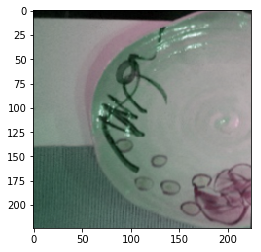

In [8]:
X_batch, y_batch = next(iter(train_dataloader))
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
plt.imshow(X_batch[0].permute(1, 2, 0).numpy() * std + mean);

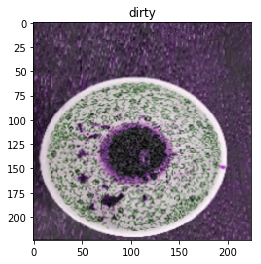

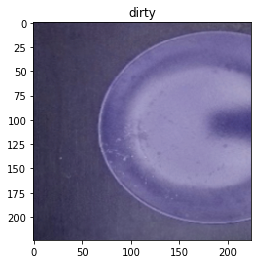

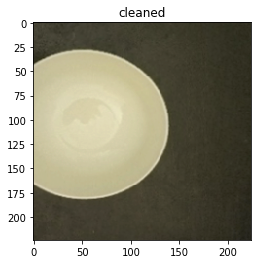

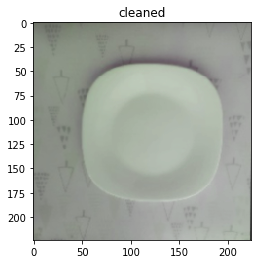

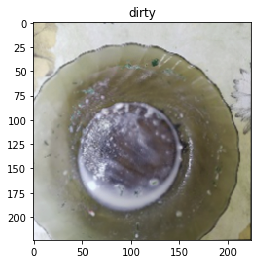

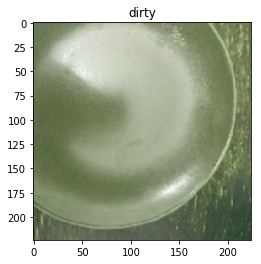

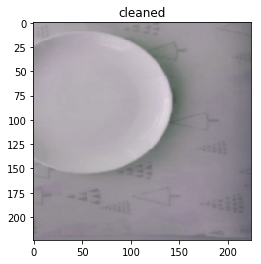

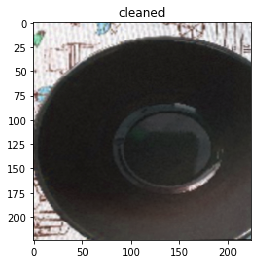

In [9]:
def show_input(input_tensor, title=''):
    image = input_tensor.permute(1, 2, 0).numpy()
    image = std * image + mean
    plt.imshow(image.clip(0, 1))
    plt.title(title)
    plt.show()
    plt.pause(0.001)

X_batch, y_batch = next(iter(train_dataloader))

for x_item, y_item in zip(X_batch, y_batch):
    show_input(x_item, title=class_names[y_item])

In [10]:
def train_model(model, loss, optimizer, scheduler, num_epochs):
    for epoch in range(num_epochs):
        print('Epoch {}/{}:'.format(epoch, num_epochs - 1), flush=True)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                dataloader = train_dataloader
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                dataloader = val_dataloader
                model.eval()   # Set model to evaluate mode

            running_loss = 0.
            running_acc = 0.

            # Iterate over data.
            for inputs, labels in tqdm(dataloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # forward and backward
                with torch.set_grad_enabled(phase == 'train'):
                    preds = model(inputs)
                    loss_value = loss(preds, labels)
                    preds_class = preds.argmax(dim=1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss_value.backward()
                        optimizer.step()

                # statistics
                running_loss += loss_value.item()
                running_acc += (preds_class == labels.data).float().mean()

            epoch_loss = running_loss / len(dataloader)
            epoch_acc = running_acc / len(dataloader)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc), flush=True)

    return model

In [11]:
model = models.resnet152(pretrained=True)

# Disable grad for all conv layers
for param in model.parameters():
    param.requires_grad = False

model.fc = torch.nn.Linear(model.fc.in_features, 2)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),amsgrad=True, lr=1.2*1.0e-3) #weight_decay=1e-3)

# Decay LR by a factor of 0.1 every 7 epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /tmp/.cache/torch/checkpoints/resnet152-b121ed2d.pth
100%|██████████| 241530880/241530880 [00:01<00:00, 137932161.97it/s]


In [12]:
train_model(model, loss, optimizer, scheduler, num_epochs=90)

Epoch 0/89:


100%|██████████| 4/4 [00:01<00:00,  2.20it/s]


train Loss: 0.9541 Acc: 0.4688


100%|██████████| 1/1 [00:00<00:00,  3.42it/s]

val Loss: 0.8980 Acc: 0.5000
Epoch 1/89:



100%|██████████| 4/4 [00:00<00:00,  4.84it/s]

train Loss: 0.8547 Acc: 0.5000



100%|██████████| 1/1 [00:00<00:00,  3.47it/s]

val Loss: 0.7360 Acc: 0.6250
Epoch 2/89:



100%|██████████| 4/4 [00:00<00:00,  4.69it/s]

train Loss: 0.7491 Acc: 0.5000



100%|██████████| 1/1 [00:00<00:00,  3.43it/s]

val Loss: 0.8550 Acc: 0.5000
Epoch 3/89:



100%|██████████| 4/4 [00:00<00:00,  4.54it/s]

train Loss: 0.6244 Acc: 0.7500



100%|██████████| 1/1 [00:00<00:00,  3.35it/s]

val Loss: 0.7188 Acc: 0.6250
Epoch 4/89:



100%|██████████| 4/4 [00:00<00:00,  4.54it/s]

train Loss: 0.5740 Acc: 0.6250



100%|██████████| 1/1 [00:00<00:00,  3.38it/s]

val Loss: 0.6927 Acc: 0.6250
Epoch 5/89:



100%|██████████| 4/4 [00:00<00:00,  4.88it/s]

train Loss: 0.4648 Acc: 0.9062



100%|██████████| 1/1 [00:00<00:00,  3.45it/s]

val Loss: 0.7254 Acc: 0.7500
Epoch 6/89:



100%|██████████| 4/4 [00:00<00:00,  4.77it/s]

train Loss: 0.4288 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  3.42it/s]

val Loss: 0.7120 Acc: 0.7500
Epoch 7/89:



100%|██████████| 4/4 [00:00<00:00,  4.66it/s]

train Loss: 0.4596 Acc: 0.8125



100%|██████████| 1/1 [00:00<00:00,  3.46it/s]

val Loss: 0.6822 Acc: 0.7500
Epoch 8/89:



100%|██████████| 4/4 [00:00<00:00,  4.75it/s]

train Loss: 0.4023 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  3.37it/s]

val Loss: 0.6633 Acc: 0.7500
Epoch 9/89:



100%|██████████| 4/4 [00:00<00:00,  4.87it/s]

train Loss: 0.3806 Acc: 0.9375



100%|██████████| 1/1 [00:00<00:00,  3.40it/s]

val Loss: 0.6482 Acc: 0.7500
Epoch 10/89:



100%|██████████| 4/4 [00:00<00:00,  4.66it/s]

train Loss: 0.3593 Acc: 0.9375



100%|██████████| 1/1 [00:00<00:00,  3.44it/s]

val Loss: 0.6418 Acc: 0.6250
Epoch 11/89:



100%|██████████| 4/4 [00:00<00:00,  4.73it/s]

train Loss: 0.4150 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  3.49it/s]

val Loss: 0.6579 Acc: 0.6250
Epoch 12/89:



100%|██████████| 4/4 [00:00<00:00,  4.58it/s]

train Loss: 0.4526 Acc: 0.9062



100%|██████████| 1/1 [00:00<00:00,  3.31it/s]

val Loss: 0.6465 Acc: 0.6250
Epoch 13/89:



100%|██████████| 4/4 [00:00<00:00,  4.73it/s]

train Loss: 0.4120 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  3.49it/s]

val Loss: 0.6534 Acc: 0.6250
Epoch 14/89:



100%|██████████| 4/4 [00:00<00:00,  4.71it/s]

train Loss: 0.3865 Acc: 0.9375



100%|██████████| 1/1 [00:00<00:00,  3.33it/s]

val Loss: 0.6600 Acc: 0.6250
Epoch 15/89:



100%|██████████| 4/4 [00:00<00:00,  4.81it/s]

train Loss: 0.3738 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  3.51it/s]

val Loss: 0.6623 Acc: 0.6250
Epoch 16/89:



100%|██████████| 4/4 [00:00<00:00,  4.89it/s]

train Loss: 0.3588 Acc: 0.9062



100%|██████████| 1/1 [00:00<00:00,  3.39it/s]

val Loss: 0.6587 Acc: 0.6250
Epoch 17/89:



100%|██████████| 4/4 [00:00<00:00,  4.64it/s]

train Loss: 0.4323 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  3.32it/s]

val Loss: 0.6574 Acc: 0.6250
Epoch 18/89:



100%|██████████| 4/4 [00:00<00:00,  4.62it/s]

train Loss: 0.3514 Acc: 0.9375



100%|██████████| 1/1 [00:00<00:00,  3.40it/s]

val Loss: 0.6648 Acc: 0.6250
Epoch 19/89:



100%|██████████| 4/4 [00:00<00:00,  4.47it/s]

train Loss: 0.4214 Acc: 0.9062



100%|██████████| 1/1 [00:00<00:00,  3.41it/s]

val Loss: 0.6558 Acc: 0.6250
Epoch 20/89:



100%|██████████| 4/4 [00:00<00:00,  4.64it/s]

train Loss: 0.3426 Acc: 0.9375



100%|██████████| 1/1 [00:00<00:00,  3.42it/s]

val Loss: 0.6540 Acc: 0.6250
Epoch 21/89:



100%|██████████| 4/4 [00:00<00:00,  4.70it/s]

train Loss: 0.3993 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  3.33it/s]

val Loss: 0.6536 Acc: 0.6250
Epoch 22/89:



100%|██████████| 4/4 [00:00<00:00,  4.65it/s]

train Loss: 0.5110 Acc: 0.8125



100%|██████████| 1/1 [00:00<00:00,  3.34it/s]

val Loss: 0.6432 Acc: 0.6250
Epoch 23/89:



100%|██████████| 4/4 [00:00<00:00,  4.65it/s]

train Loss: 0.3791 Acc: 0.9375



100%|██████████| 1/1 [00:00<00:00,  3.39it/s]

val Loss: 0.6480 Acc: 0.6250
Epoch 24/89:



100%|██████████| 4/4 [00:00<00:00,  4.84it/s]

train Loss: 0.4226 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  3.42it/s]

val Loss: 0.6590 Acc: 0.6250
Epoch 25/89:



100%|██████████| 4/4 [00:00<00:00,  4.66it/s]

train Loss: 0.3878 Acc: 0.9062



100%|██████████| 1/1 [00:00<00:00,  3.31it/s]

val Loss: 0.6406 Acc: 0.6250
Epoch 26/89:



100%|██████████| 4/4 [00:00<00:00,  4.50it/s]

train Loss: 0.3946 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  3.53it/s]

val Loss: 0.6539 Acc: 0.6250
Epoch 27/89:



100%|██████████| 4/4 [00:00<00:00,  4.64it/s]

train Loss: 0.3935 Acc: 0.9062



100%|██████████| 1/1 [00:00<00:00,  3.43it/s]

val Loss: 0.6463 Acc: 0.6250
Epoch 28/89:



100%|██████████| 4/4 [00:00<00:00,  4.69it/s]

train Loss: 0.3623 Acc: 0.9062



100%|██████████| 1/1 [00:00<00:00,  3.42it/s]

val Loss: 0.6279 Acc: 0.6250
Epoch 29/89:



100%|██████████| 4/4 [00:00<00:00,  4.69it/s]

train Loss: 0.3347 Acc: 0.9062



100%|██████████| 1/1 [00:00<00:00,  3.42it/s]

val Loss: 0.6354 Acc: 0.6250
Epoch 30/89:



100%|██████████| 4/4 [00:00<00:00,  4.81it/s]

train Loss: 0.4441 Acc: 0.8125



100%|██████████| 1/1 [00:00<00:00,  3.27it/s]

val Loss: 0.6214 Acc: 0.7500
Epoch 31/89:



100%|██████████| 4/4 [00:00<00:00,  4.88it/s]

train Loss: 0.3983 Acc: 0.9062



100%|██████████| 1/1 [00:00<00:00,  3.35it/s]

val Loss: 0.6293 Acc: 0.7500
Epoch 32/89:



100%|██████████| 4/4 [00:00<00:00,  4.59it/s]

train Loss: 0.3845 Acc: 0.9062



100%|██████████| 1/1 [00:00<00:00,  3.41it/s]

val Loss: 0.6426 Acc: 0.6250
Epoch 33/89:



100%|██████████| 4/4 [00:00<00:00,  4.67it/s]

train Loss: 0.4724 Acc: 0.9375



100%|██████████| 1/1 [00:00<00:00,  3.48it/s]

val Loss: 0.6419 Acc: 0.6250
Epoch 34/89:



100%|██████████| 4/4 [00:00<00:00,  4.65it/s]

train Loss: 0.3742 Acc: 0.9688



100%|██████████| 1/1 [00:00<00:00,  3.38it/s]

val Loss: 0.6413 Acc: 0.6250
Epoch 35/89:



100%|██████████| 4/4 [00:00<00:00,  4.69it/s]

train Loss: 0.4755 Acc: 0.8125



100%|██████████| 1/1 [00:00<00:00,  3.42it/s]

val Loss: 0.6563 Acc: 0.6250
Epoch 36/89:



100%|██████████| 4/4 [00:00<00:00,  4.78it/s]

train Loss: 0.3687 Acc: 0.9062



100%|██████████| 1/1 [00:00<00:00,  3.40it/s]

val Loss: 0.6462 Acc: 0.6250
Epoch 37/89:



100%|██████████| 4/4 [00:00<00:00,  4.69it/s]

train Loss: 0.3792 Acc: 0.9062



100%|██████████| 1/1 [00:00<00:00,  3.50it/s]

val Loss: 0.6474 Acc: 0.7500
Epoch 38/89:



100%|██████████| 4/4 [00:00<00:00,  4.71it/s]

train Loss: 0.4415 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  3.41it/s]

val Loss: 0.6489 Acc: 0.6250
Epoch 39/89:



100%|██████████| 4/4 [00:00<00:00,  4.93it/s]

train Loss: 0.3561 Acc: 0.9688



100%|██████████| 1/1 [00:00<00:00,  3.26it/s]

val Loss: 0.6251 Acc: 0.6250
Epoch 40/89:



100%|██████████| 4/4 [00:00<00:00,  4.93it/s]

train Loss: 0.3461 Acc: 0.9062



100%|██████████| 1/1 [00:00<00:00,  3.46it/s]

val Loss: 0.6254 Acc: 0.6250
Epoch 41/89:



100%|██████████| 4/4 [00:00<00:00,  4.74it/s]

train Loss: 0.3714 Acc: 0.9062



100%|██████████| 1/1 [00:00<00:00,  3.46it/s]

val Loss: 0.6282 Acc: 0.6250
Epoch 42/89:



100%|██████████| 4/4 [00:00<00:00,  4.61it/s]

train Loss: 0.3517 Acc: 0.9375



100%|██████████| 1/1 [00:00<00:00,  3.33it/s]

val Loss: 0.6449 Acc: 0.6250
Epoch 43/89:



100%|██████████| 4/4 [00:00<00:00,  4.66it/s]

train Loss: 0.4104 Acc: 0.9062



100%|██████████| 1/1 [00:00<00:00,  3.30it/s]

val Loss: 0.6459 Acc: 0.6250
Epoch 44/89:



100%|██████████| 4/4 [00:00<00:00,  4.87it/s]

train Loss: 0.3609 Acc: 0.9062



100%|██████████| 1/1 [00:00<00:00,  3.31it/s]

val Loss: 0.6485 Acc: 0.6250
Epoch 45/89:



100%|██████████| 4/4 [00:00<00:00,  4.54it/s]

train Loss: 0.3992 Acc: 0.9375



100%|██████████| 1/1 [00:00<00:00,  3.40it/s]

val Loss: 0.6567 Acc: 0.6250
Epoch 46/89:



100%|██████████| 4/4 [00:00<00:00,  4.57it/s]

train Loss: 0.4658 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  3.36it/s]

val Loss: 0.6477 Acc: 0.6250
Epoch 47/89:



100%|██████████| 4/4 [00:00<00:00,  4.72it/s]

train Loss: 0.3311 Acc: 1.0000



100%|██████████| 1/1 [00:00<00:00,  3.21it/s]

val Loss: 0.6457 Acc: 0.6250
Epoch 48/89:



100%|██████████| 4/4 [00:00<00:00,  4.57it/s]

train Loss: 0.3995 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  3.42it/s]

val Loss: 0.6390 Acc: 0.6250
Epoch 49/89:



100%|██████████| 4/4 [00:00<00:00,  4.64it/s]

train Loss: 0.3928 Acc: 0.9375



100%|██████████| 1/1 [00:00<00:00,  3.34it/s]

val Loss: 0.6360 Acc: 0.6250
Epoch 50/89:



100%|██████████| 4/4 [00:00<00:00,  4.56it/s]

train Loss: 0.3523 Acc: 0.9375



100%|██████████| 1/1 [00:00<00:00,  3.39it/s]

val Loss: 0.6445 Acc: 0.6250
Epoch 51/89:



100%|██████████| 4/4 [00:00<00:00,  4.52it/s]

train Loss: 0.4079 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  3.31it/s]

val Loss: 0.6577 Acc: 0.6250
Epoch 52/89:



100%|██████████| 4/4 [00:00<00:00,  4.78it/s]

train Loss: 0.4024 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  3.36it/s]

val Loss: 0.6502 Acc: 0.6250
Epoch 53/89:



100%|██████████| 4/4 [00:00<00:00,  4.71it/s]

train Loss: 0.3709 Acc: 0.9688



100%|██████████| 1/1 [00:00<00:00,  3.40it/s]

val Loss: 0.6504 Acc: 0.6250
Epoch 54/89:



100%|██████████| 4/4 [00:00<00:00,  4.59it/s]

train Loss: 0.3830 Acc: 0.9375



100%|██████████| 1/1 [00:00<00:00,  3.42it/s]

val Loss: 0.6387 Acc: 0.6250
Epoch 55/89:



100%|██████████| 4/4 [00:00<00:00,  4.49it/s]

train Loss: 0.4266 Acc: 0.8125



100%|██████████| 1/1 [00:00<00:00,  3.49it/s]

val Loss: 0.6522 Acc: 0.6250
Epoch 56/89:



100%|██████████| 4/4 [00:00<00:00,  4.70it/s]

train Loss: 0.3707 Acc: 1.0000



100%|██████████| 1/1 [00:00<00:00,  3.35it/s]

val Loss: 0.6454 Acc: 0.6250
Epoch 57/89:



100%|██████████| 4/4 [00:00<00:00,  4.63it/s]

train Loss: 0.4563 Acc: 0.8125



100%|██████████| 1/1 [00:00<00:00,  3.41it/s]

val Loss: 0.6400 Acc: 0.6250
Epoch 58/89:



100%|██████████| 4/4 [00:00<00:00,  4.72it/s]

train Loss: 0.3842 Acc: 0.9375



100%|██████████| 1/1 [00:00<00:00,  3.37it/s]

val Loss: 0.6348 Acc: 0.6250
Epoch 59/89:



100%|██████████| 4/4 [00:00<00:00,  4.55it/s]

train Loss: 0.4186 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  3.39it/s]

val Loss: 0.6469 Acc: 0.6250
Epoch 60/89:



100%|██████████| 4/4 [00:00<00:00,  3.79it/s]

train Loss: 0.4250 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  3.21it/s]

val Loss: 0.6568 Acc: 0.6250
Epoch 61/89:



100%|██████████| 4/4 [00:00<00:00,  4.77it/s]

train Loss: 0.4130 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  3.34it/s]

val Loss: 0.6678 Acc: 0.6250
Epoch 62/89:



100%|██████████| 4/4 [00:00<00:00,  4.57it/s]

train Loss: 0.3910 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  3.41it/s]

val Loss: 0.6535 Acc: 0.6250
Epoch 63/89:



100%|██████████| 4/4 [00:00<00:00,  4.50it/s]

train Loss: 0.4790 Acc: 0.7812



100%|██████████| 1/1 [00:00<00:00,  3.36it/s]

val Loss: 0.6520 Acc: 0.6250
Epoch 64/89:



100%|██████████| 4/4 [00:00<00:00,  4.64it/s]

train Loss: 0.4523 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  3.25it/s]

val Loss: 0.6378 Acc: 0.6250
Epoch 65/89:



100%|██████████| 4/4 [00:00<00:00,  4.65it/s]

train Loss: 0.3373 Acc: 1.0000



100%|██████████| 1/1 [00:00<00:00,  3.36it/s]

val Loss: 0.6449 Acc: 0.6250
Epoch 66/89:



100%|██████████| 4/4 [00:00<00:00,  4.51it/s]

train Loss: 0.4362 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  3.42it/s]

val Loss: 0.6458 Acc: 0.6250
Epoch 67/89:



100%|██████████| 4/4 [00:00<00:00,  4.60it/s]

train Loss: 0.4265 Acc: 0.9062



100%|██████████| 1/1 [00:00<00:00,  3.33it/s]

val Loss: 0.6406 Acc: 0.6250
Epoch 68/89:



100%|██████████| 4/4 [00:00<00:00,  3.62it/s]

train Loss: 0.3954 Acc: 0.9062



100%|██████████| 1/1 [00:00<00:00,  3.28it/s]

val Loss: 0.6341 Acc: 0.6250
Epoch 69/89:



100%|██████████| 4/4 [00:00<00:00,  4.53it/s]

train Loss: 0.3924 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  3.33it/s]

val Loss: 0.6288 Acc: 0.6250
Epoch 70/89:



100%|██████████| 4/4 [00:00<00:00,  4.62it/s]

train Loss: 0.3912 Acc: 0.9375



100%|██████████| 1/1 [00:00<00:00,  3.39it/s]

val Loss: 0.6292 Acc: 0.6250
Epoch 71/89:



100%|██████████| 4/4 [00:00<00:00,  4.58it/s]

train Loss: 0.4199 Acc: 0.9062



100%|██████████| 1/1 [00:00<00:00,  3.31it/s]

val Loss: 0.6280 Acc: 0.6250
Epoch 72/89:



100%|██████████| 4/4 [00:00<00:00,  4.84it/s]

train Loss: 0.3874 Acc: 0.9062



100%|██████████| 1/1 [00:00<00:00,  3.24it/s]

val Loss: 0.6384 Acc: 0.6250
Epoch 73/89:



100%|██████████| 4/4 [00:00<00:00,  4.53it/s]

train Loss: 0.3895 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  3.31it/s]

val Loss: 0.6474 Acc: 0.6250
Epoch 74/89:



100%|██████████| 4/4 [00:00<00:00,  4.60it/s]

train Loss: 0.4208 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  3.36it/s]

val Loss: 0.6512 Acc: 0.6250
Epoch 75/89:



100%|██████████| 4/4 [00:00<00:00,  4.66it/s]

train Loss: 0.3909 Acc: 0.9062



100%|██████████| 1/1 [00:00<00:00,  3.37it/s]

val Loss: 0.6426 Acc: 0.6250
Epoch 76/89:



100%|██████████| 4/4 [00:00<00:00,  4.59it/s]

train Loss: 0.3882 Acc: 0.9375



100%|██████████| 1/1 [00:00<00:00,  3.31it/s]

val Loss: 0.6318 Acc: 0.6250
Epoch 77/89:



100%|██████████| 4/4 [00:00<00:00,  4.63it/s]

train Loss: 0.4007 Acc: 0.9062



100%|██████████| 1/1 [00:00<00:00,  3.50it/s]

val Loss: 0.6292 Acc: 0.6250
Epoch 78/89:



100%|██████████| 4/4 [00:00<00:00,  4.63it/s]

train Loss: 0.4195 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  3.36it/s]

val Loss: 0.6376 Acc: 0.6250
Epoch 79/89:



100%|██████████| 4/4 [00:00<00:00,  4.61it/s]

train Loss: 0.3664 Acc: 0.9062



100%|██████████| 1/1 [00:00<00:00,  3.33it/s]

val Loss: 0.6351 Acc: 0.6250
Epoch 80/89:



100%|██████████| 4/4 [00:00<00:00,  4.57it/s]

train Loss: 0.3398 Acc: 0.9688



100%|██████████| 1/1 [00:00<00:00,  3.31it/s]

val Loss: 0.6437 Acc: 0.6250
Epoch 81/89:



100%|██████████| 4/4 [00:00<00:00,  4.72it/s]

train Loss: 0.4264 Acc: 0.8125



100%|██████████| 1/1 [00:00<00:00,  3.42it/s]

val Loss: 0.6423 Acc: 0.6250
Epoch 82/89:



100%|██████████| 4/4 [00:00<00:00,  4.90it/s]

train Loss: 0.3913 Acc: 0.9062



100%|██████████| 1/1 [00:00<00:00,  3.39it/s]

val Loss: 0.6341 Acc: 0.6250
Epoch 83/89:



100%|██████████| 4/4 [00:00<00:00,  4.64it/s]

train Loss: 0.4137 Acc: 0.9375



100%|██████████| 1/1 [00:00<00:00,  3.41it/s]

val Loss: 0.6246 Acc: 0.6250
Epoch 84/89:



100%|██████████| 4/4 [00:00<00:00,  4.71it/s]

train Loss: 0.3715 Acc: 0.9375



100%|██████████| 1/1 [00:00<00:00,  3.48it/s]

val Loss: 0.6277 Acc: 0.7500
Epoch 85/89:



100%|██████████| 4/4 [00:00<00:00,  4.76it/s]

train Loss: 0.4090 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  3.31it/s]

val Loss: 0.6392 Acc: 0.6250
Epoch 86/89:



100%|██████████| 4/4 [00:00<00:00,  4.82it/s]

train Loss: 0.3805 Acc: 0.9375



100%|██████████| 1/1 [00:00<00:00,  3.40it/s]

val Loss: 0.6423 Acc: 0.6250
Epoch 87/89:



100%|██████████| 4/4 [00:00<00:00,  4.78it/s]

train Loss: 0.4269 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  3.48it/s]

val Loss: 0.6409 Acc: 0.6250
Epoch 88/89:



100%|██████████| 4/4 [00:00<00:00,  4.69it/s]

train Loss: 0.3445 Acc: 0.9688



100%|██████████| 1/1 [00:00<00:00,  3.46it/s]

val Loss: 0.6453 Acc: 0.6250
Epoch 89/89:



100%|██████████| 4/4 [00:00<00:00,  4.81it/s]

train Loss: 0.3762 Acc: 0.9375



100%|██████████| 1/1 [00:00<00:00,  3.44it/s]

val Loss: 0.6462 Acc: 0.6250


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

In [13]:
test_dir = 'test'
shutil.copytree(os.path.join(data_root, 'test'), os.path.join(test_dir, 'unknown'))

'test/unknown'

In [14]:
class ImageFolderWithPaths(torchvision.datasets.ImageFolder):
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        path = self.imgs[index][0]
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path
    
test_dataset = ImageFolderWithPaths(test_dir, val_transforms)

test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=batch_size)

In [15]:
model.eval()

test_predictions = []
test_img_paths = []
for inputs, labels, paths in tqdm(test_dataloader):
    inputs = inputs.to(device)
    labels = labels.to(device)
    with torch.set_grad_enabled(False):
        preds = model(inputs)
    test_predictions.append(
        torch.nn.functional.softmax(preds, dim=1)[:,1].data.cpu().numpy())
    test_img_paths.extend(paths)
    
test_predictions = np.concatenate(test_predictions)

100%|██████████| 93/93 [00:06<00:00, 14.12it/s]


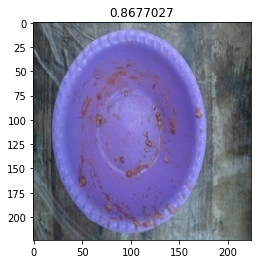

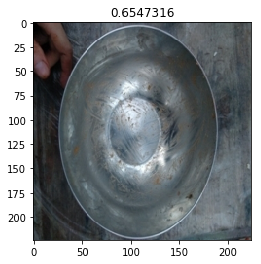

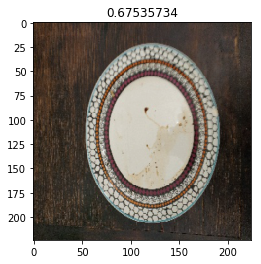

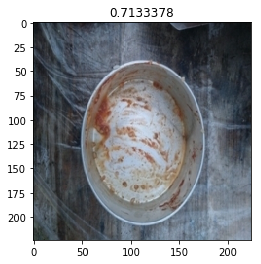

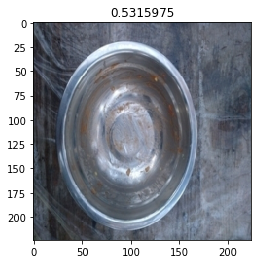

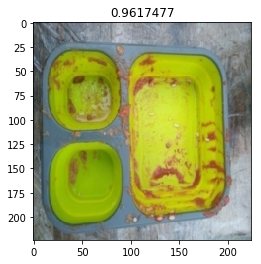

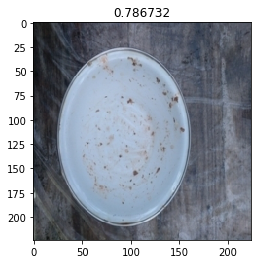

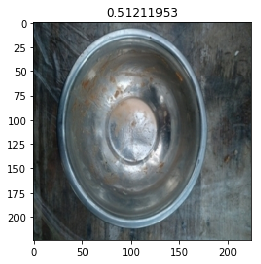

In [16]:
inputs, labels, paths = next(iter(test_dataloader))

for img, pred in zip(inputs, test_predictions):
    show_input(img, title=pred)

In [17]:
submission_df = pd.DataFrame.from_dict({'id': test_img_paths, 'label': test_predictions})

In [18]:
submission_df['label'] = submission_df['label'].map(lambda pred: 'dirty' if pred > 0.5 else 'cleaned')
submission_df['id'] = submission_df['id'].str.replace('test/unknown/', '')
submission_df['id'] = submission_df['id'].str.replace('.jpg', '')
submission_df.set_index('id', inplace=True)
submission_df.head(n=6)

,label
id,
0000,dirty
0001,dirty
0002,dirty
0003,dirty
0004,dirty
0005,dirty


In [19]:
submission_df.to_csv('submission.csv')

In [20]:
!rm -rf train val test